In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.8 MB/s eta 0:00:00


# **1. LIBRARY**

In [2]:
import tensorflow as tf
import keras
import numpy as np
from tensorflow.keras import datasets, Model
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Input
import matplotlib.pyplot as plt
from google.colab import drive
import os
from datasets import load_dataset
import pandas as pd
from PIL import Image
import io
from tensorflow.keras.applications import VGG16
import pathlib
import matplotlib.image as mpimg
from sklearn.metrics import classification_report
import shutil
import glob
from sklearn.model_selection import train_test_split
drive.mount('/content/drive')

Mounted at /content/drive


# **2. DATA PREPROCESSING**

In [3]:
dataset = load_dataset("sagecontinuum/smokedataset")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14318 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3671 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1843 [00:00<?, ? examples/s]

In [4]:
label_names = {0: 'cloud', 1: 'other', 2: 'smoke'}

def save_images(dataset_split, directory):
    os.makedirs(directory, exist_ok=True)

    for i, item in enumerate(dataset_split):
        # Dapatkan label untuk gambar saat ini dan ubah menjadi nama yang sesuai
        label_num = item['label']
        label_name = label_names[label_num]  # Menggunakan kamus untuk mendapatkan nama label

        # Buat subfolder untuk label jika belum ada
        label_dir = os.path.join(directory, label_name)  # Menggunakan nama label dari kamus
        os.makedirs(label_dir, exist_ok=True)

        # Menyimpan gambar di dalam subfolder label yang sesuai
        image_path = os.path.join(label_dir, f'image_{i}.png')
        item['image'].save(image_path)
        print(f'Gambar disimpan: {image_path}')

# Menyimpan gambar dari setiap split dataset ke folder yang sesuai di Google Drive
save_images(dataset['train'], '/content/drive/My Drive/smokedatasetHF')
save_images(dataset['validation'], '/content/drive/My Drive/smokedatasetHF')
save_images(dataset['test'], '/content/drive/My Drive/smokedatasetHF')

Output streaming akan dipotong hingga 5000 baris terakhir.
Gambar disimpan: /content/drive/My Drive/smokedatasetHF/other/image_514.png
Gambar disimpan: /content/drive/My Drive/smokedatasetHF/other/image_515.png
Gambar disimpan: /content/drive/My Drive/smokedatasetHF/other/image_516.png
Gambar disimpan: /content/drive/My Drive/smokedatasetHF/other/image_517.png
Gambar disimpan: /content/drive/My Drive/smokedatasetHF/other/image_518.png
Gambar disimpan: /content/drive/My Drive/smokedatasetHF/other/image_519.png
Gambar disimpan: /content/drive/My Drive/smokedatasetHF/other/image_520.png
Gambar disimpan: /content/drive/My Drive/smokedatasetHF/other/image_521.png
Gambar disimpan: /content/drive/My Drive/smokedatasetHF/other/image_522.png
Gambar disimpan: /content/drive/My Drive/smokedatasetHF/other/image_523.png
Gambar disimpan: /content/drive/My Drive/smokedatasetHF/other/image_524.png
Gambar disimpan: /content/drive/My Drive/smokedatasetHF/other/image_525.png
Gambar disimpan: /content/dri

> Dataset diambil dari HuggingFace: https://huggingface.co/datasets/sagecontinuum/smokedataset

> Kode di atas menyimpan seluruh subset `sagecontinuum/smokedataset` (*train*, *validation*, *test*) di dalam 1 folder `smokedatasetHF` untuk nanti dilakukan *splitting* *train data* sebesar 80% dan *test data* sebesar 20%

In [5]:
smokedata_set_dir = "/content/drive/My Drive/smokedatasetHF"

> Menyimpan *train data* dan *test data* yang telah displit ke folder `smokedatasetHF`, untuk *train data* yang displit 80% disimpan di folder `train_smoke` yang ada di dalam folder `smokedatasetHF` dan untuk *test data* yang displit 20% disimpan di folder `test_smoke` yang ada di dalam folder `smokedatasetHF`

In [6]:
def get_image_paths_and_labels(directory):
    image_paths = []
    labels = []
    for label_dir in os.listdir(directory):
        full_label_dir = os.path.join(directory, label_dir)
        if os.path.isdir(full_label_dir):
            for image_path in glob.glob(os.path.join(full_label_dir, '*.png')):
                image_paths.append(image_path)
                labels.append(label_dir)
    return image_paths, labels

image_paths, labels = get_image_paths_and_labels(smokedata_set_dir)

In [7]:
# Buat mapping dari label string ke integer
label_to_int = {'cloud': 0, 'other': 1, 'smoke': 2}

# Gunakan mapping untuk mengonversi labels ke integer
labels_int = [label_to_int[label] for label in labels]

# Lanjutkan dengan train_test_split
image_paths_train, image_paths_test, labels_train, labels_test = train_test_split(
    image_paths, labels_int, test_size=0.2, random_state=42)

> Karena aturannya adalah *dataset* harus displit untuk *train data* sebesar 80% dan juga *test data* sebesar 20%, maka `test_size` diatur 0.2

In [8]:
# Mendefinisikan kamus untuk mapping angka label ke nama label
label_names = {0: 'cloud', 1: 'other', 2: 'smoke'}

def save_split_images(image_paths, labels, directory):
    os.makedirs(directory, exist_ok=True)

    for image_path, label in zip(image_paths, labels):
        # Gunakan kamus untuk mendapatkan nama label dari angka label
        label_name = label_names[label]

        # Buat subfolder dengan nama label yang sesuai
        label_dir = os.path.join(directory, label_name)
        os.makedirs(label_dir, exist_ok=True)

        # Copy gambar ke direktori yang sesuai
        dest_path = os.path.join(label_dir, os.path.basename(image_path))
        shutil.copy(image_path, dest_path)
        print(f'Gambar {os.path.basename(image_path)} disimpan ke {dest_path}')

# Menyimpan gambar ke direktori yang sesuai
train_set_dir = '/content/drive/My Drive/smokedatasetHF/train_smoke'
test_set_dir = '/content/drive/My Drive/smokedatasetHF/test_smoke'

save_split_images(image_paths_train, labels_train, train_set_dir)
save_split_images(image_paths_test, labels_test, test_set_dir)

Output streaming akan dipotong hingga 5000 baris terakhir.
Gambar image_7979.png disimpan ke /content/drive/My Drive/smokedatasetHF/train_smoke/smoke/image_7979.png
Gambar image_306.png disimpan ke /content/drive/My Drive/smokedatasetHF/train_smoke/other/image_306.png
Gambar image_2003.png disimpan ke /content/drive/My Drive/smokedatasetHF/train_smoke/smoke/image_2003.png
Gambar image_4790.png disimpan ke /content/drive/My Drive/smokedatasetHF/train_smoke/other/image_4790.png
Gambar image_2356.png disimpan ke /content/drive/My Drive/smokedatasetHF/train_smoke/other/image_2356.png
Gambar image_10286.png disimpan ke /content/drive/My Drive/smokedatasetHF/train_smoke/cloud/image_10286.png
Gambar image_10388.png disimpan ke /content/drive/My Drive/smokedatasetHF/train_smoke/cloud/image_10388.png
Gambar image_1927.png disimpan ke /content/drive/My Drive/smokedatasetHF/train_smoke/other/image_1927.png
Gambar image_1555.png disimpan ke /content/drive/My Drive/smokedatasetHF/train_smoke/cloud/

In [9]:
train_smoke_dir = '/content/drive/MyDrive/smokedatasetHF/train_smoke'
test_smoke_dir = '/content/drive/MyDrive/smokedatasetHF/test_smoke'

In [10]:
training_set = image_dataset_from_directory(
    directory = train_smoke_dir,
    image_size = (224, 224),
    label_mode = "categorical",
    batch_size = 32,
    seed = 42
)

test_set = image_dataset_from_directory(
    directory = test_smoke_dir,
    image_size = (224, 224),
    label_mode = "categorical"
)

Found 14083 files belonging to 3 classes.
Found 3521 files belonging to 3 classes.


In [11]:
# Normalisasi Data Gambar
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255.0, label

training_set = training_set.map(normalize)
test_set = test_set.map(normalize)

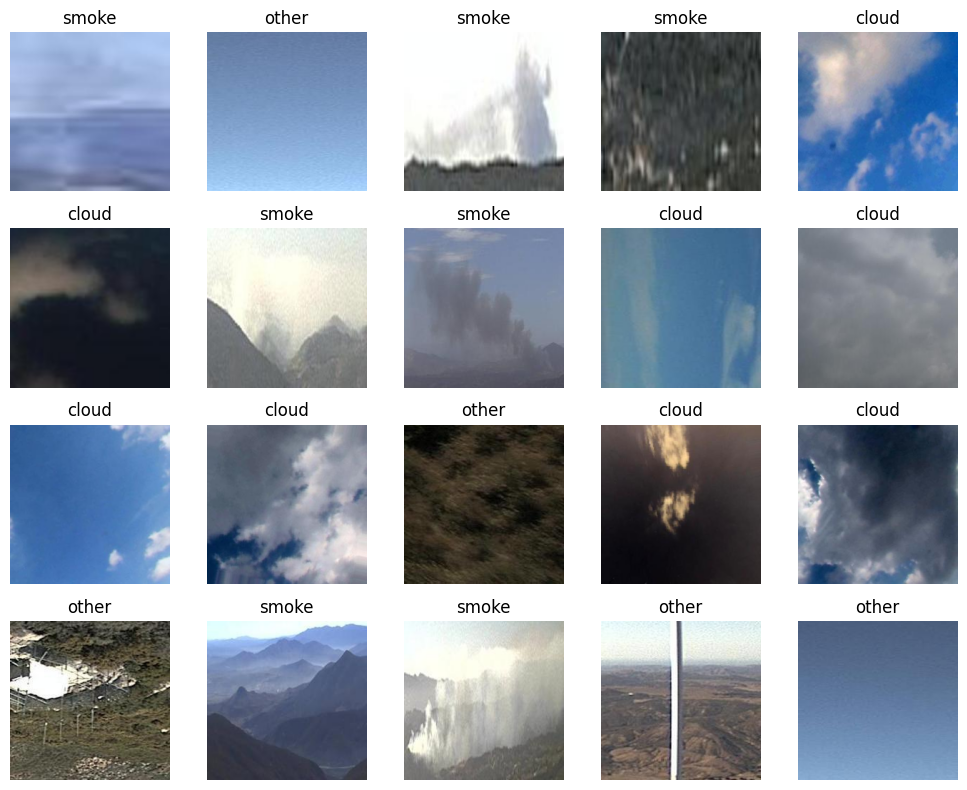

In [12]:
class_names = dataset['train'].features['label'].names

def show_batch(dataset, rows, cols):
    plt.figure(figsize=(10, 8))
    dataset = dataset.unbatch().batch(rows * cols)
    for images, labels in dataset.take(1):
        # Ambil satu batch gambar
        for i in range(rows * cols):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(images[i].numpy())
            label = class_names[np.argmax(labels[i].numpy())]
            plt.title(label)
            plt.axis("off")
    plt.tight_layout()
    plt.show()

# Tampilkan 20 gambar acak dari training_set dengan label
show_batch(training_set, rows=4, cols=5)

# **3. MODEL BUILDING & DATA MODELLING**

In [13]:
pretrained_model = VGG16(
    weights = "imagenet",
    include_top = False,
    pooling = "max"
)

pretrained_model.trainable = False

inputs = Input(shape = (224, 224, 3), name ="input_layer")

revised_model_3 = pretrained_model(inputs)

outputs = Dense(units = 3, activation = "softmax",
                name="output_layer")(revised_model_3)

model_3 = Model(inputs, outputs, name = "model_3")

model_3.compile(loss="categorical_crossentropy",
                optimizer="adam",
                metrics="accuracy")

model_3.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 output_layer (Dense)        (None, 3)                 1539      
                                                                 
Total params: 14716227 (56.14 MB)
Trainable params: 1539 (6.01 KB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


> Menggunakan *pre-trained model* `VGG-16` untuk `sagecontinuum/smokedataset` (melakukan *transfer learning*), yang mana di dalam arsitektur model `VGG16` terdapat `Conv2D Maxpooling Layer` (seperti pada gambar di bawah) dan model `VGG-16` merupakan model *Sequential*

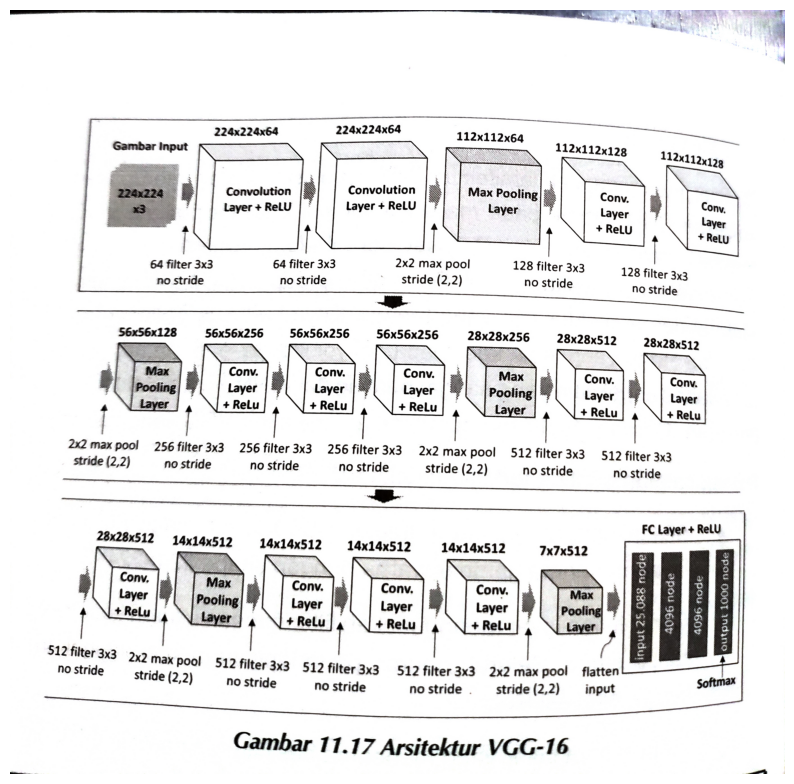

In [14]:
image_path = '/content/drive/MyDrive/VGG16 Architecture.jpg'

image = mpimg.imread(image_path)

plt.figure(figsize=(10, 10))

plt.imshow(image)
plt.axis('off')
plt.show()

> Diketahui pada gambar Arsitektur model `VGG-16`, terdapat 5 `Conv2D Maxpooling Layer`. Gambar tersebut diambil dari buku:

        Pahlevi, S. M. (2023). Kecerdasan Buatan dengan Deep Learning. Elex Media Komputindo.

In [15]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, model_path, target_acc=0.94):
        super(CustomCallback, self).__init__()
        self.model_path = model_path
        self.target_acc = target_acc

    def on_epoch_end(self, epoch, logs=None):
        train_acc = logs.get('accuracy')
        val_acc = logs.get('val_accuracy')
        if train_acc is not None and val_acc is not None:
            if train_acc >= self.target_acc and val_acc >= self.target_acc:
                print(f"\nReached {self.target_acc * 100}% accuracy for both training and validation. Stopping training...")
                self.model.save(self.model_path)
                self.model.stop_training = True

custom_callback = CustomCallback(model_path="/content/drive/MyDrive/FP IDCAMP 23/best_model_3.hdf5")

history = model_3.fit(training_set,
                      epochs=100,
                      validation_data=test_set,
                      callbacks=[custom_callback])

Epoch 1/100
441/441 [==============================] - 110s 228ms/step - loss: 0.6026 - accuracy: 0.7885 - val_loss: 0.4412 - val_accuracy: 0.8779
Epoch 2/100
441/441 [==============================] - 91s 204ms/step - loss: 0.3784 - accuracy: 0.8916 - val_loss: 0.3558 - val_accuracy: 0.8892
Epoch 3/100
441/441 [==============================] - 90s 201ms/step - loss: 0.3189 - accuracy: 0.9056 - val_loss: 0.3168 - val_accuracy: 0.9006
Epoch 4/100
441/441 [==============================] - 92s 207ms/step - loss: 0.2846 - accuracy: 0.9147 - val_loss: 0.2895 - val_accuracy: 0.9097
Epoch 5/100
441/441 [==============================] - 91s 203ms/step - loss: 0.2621 - accuracy: 0.9200 - val_loss: 0.2697 - val_accuracy: 0.9125
Epoch 6/100
441/441 [==============================] - 89s 198ms/step - loss: 0.2445 - accuracy: 0.9264 - val_loss: 0.2554 - val_accuracy: 0.9193
Epoch 7/100
441/441 [==============================] - 88s 198ms/step - loss: 0.2318 - accuracy: 0.9281 - val_loss: 0.2465 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


441/441 [==============================] - 89s 200ms/step - loss: 0.1602 - accuracy: 0.9480 - val_loss: 0.1814 - val_accuracy: 0.9418


> Menggunakan `CustomCallback`, dimana jika *training accuracy* dan juga *validation accuracy* telah menyentuh 94% atau minimal 0.94, maka model `VGG-16` berhenti melakukan proses *data training*. Didapatkan bahwa hanya membutuhkan 22 *epochs* untuk mencapai *training accuracy* dan *validation accuracy* 94%, artinya adalah memang model `VGG-16` ini sangat cocok dan bagus untuk digunakan pada `sagecontinuum/smokedataset`

# **4. MODEL EVALUATION**

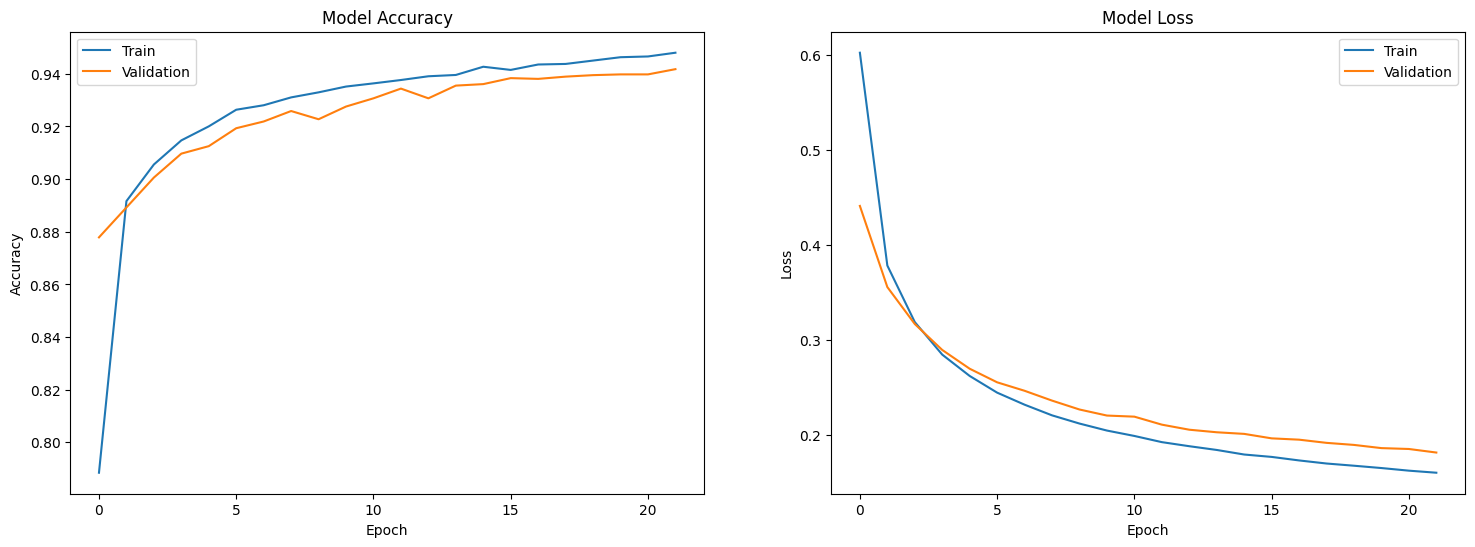

In [16]:
# Set up the matplotlib figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train')
ax1.plot(history.history['val_accuracy'], label='Validation')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')

# Plot loss
ax2.plot(history.history['loss'], label='Train')
ax2.plot(history.history['val_loss'], label='Validation')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

In [17]:
best_model_3 = load_model("/content/drive/My Drive/FP IDCAMP 23/best_model_3.hdf5")

1/1 [==============================] - 5s 5s/step


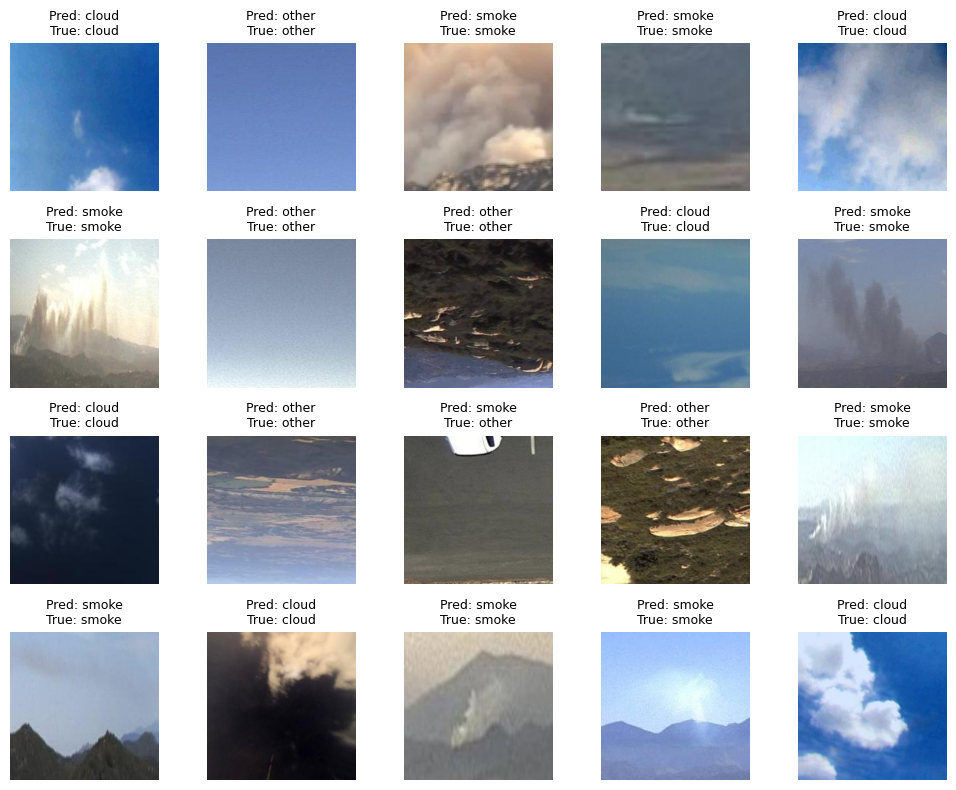

In [18]:
def show_predictions(dataset, model, class_names, num_images=20, images_per_row=5):
    # Mengambil sampel dari dataset
    test_samples = dataset.unbatch().batch(num_images)
    images, labels = next(iter(test_samples))

    # Melakukan prediksi
    preds = model.predict(images)

    # Menentukan jumlah baris berdasarkan jumlah gambar dan gambar per baris
    num_rows = num_images // images_per_row + (num_images % images_per_row > 0)

    # Menampilkan gambar, label asli, dan prediksi
    fig, axes = plt.subplots(nrows=num_rows, ncols=images_per_row, figsize=(2*images_per_row, 2*num_rows))
    axes = axes.flatten()

    for i, (img, label, pred) in enumerate(zip(images, labels, preds)):
        if i >= num_images: break  # Jika sudah mencapai jumlah gambar maksimum, berhenti
        ax = axes[i]
        ax.imshow(img.numpy())
        pred_label = class_names[np.argmax(pred)]
        true_label = class_names[np.argmax(label.numpy())]
        ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}", fontsize=9)
        ax.axis('off')

    # Sembunyikan subplot kosong jika ada
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Contoh pemanggilan fungsi
show_predictions(test_set, best_model_3, class_names, num_images=20, images_per_row=5)

# **5. From SavedModel to TFLite Format**

In [19]:
# Menyimpan model dalam format SavedModel
export_dir = '/content/drive/MyDrive/FP IDCAMP 23/saved_model/'
tf.saved_model.save(best_model_3, export_dir)

# Convert SavedModel menjadi smoke_predict.tflite
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

tflite_model_file = pathlib.Path('/content/drive/MyDrive/FP IDCAMP 23/smoke_predict.tflite')
tflite_model_file.write_bytes(tflite_model)

58874724